In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import re
#import seaborn as sns
#from wordcloud import WordCloud
import matplotlib.pyplot as plt
#from nltk.stem import WordNetLemmatizer
#import nltk
#nltk.download('omw-1.4')
#matplotlib.use('TkAgg')
import networkx as nx
from networkx.algorithms.community.modularity_max import greedy_modularity_communities
from scipy.linalg import sqrtm 
from sklearn.datasets import load_breast_cancer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import precision_recall_curve 
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


In [ ]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
dataset1 = load_breast_cancer()

In [3]:
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.metrics
import sklearn.linear_model
import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import random
from random import *
val=4



In [4]:
fname="movies1.csv"
df = pd.read_csv(fname)

In [5]:
df['attribute'].value_counts()

Thriller     1170
Crime         743
Comedy        577
Horror        545
Romance       303
Adventure     272
Action        206
War            41
Animation      26
Name: attribute, dtype: int64

In [6]:
# length of dataset
len(df)
df.info()
ndcg=[0.332,0.321,0.31,0.30,0.29,0.28,0.276,0.27,0.26]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sno        3883 non-null   int64 
 1   title      3883 non-null   object
 2   attribute  3883 non-null   object
 3   gender     3883 non-null   object
 4   age        3883 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 151.8+ KB


In [7]:
np.sum(df.isnull())

sno          0
title        0
attribute    0
gender       0
age          0
dtype: int64

In [8]:
# storing the data in lists
tweet, type = list(df['gender']), list(df['attribute'])
recall=[0.321,0.31,0.30,0.29,0.28,0.276,0.273,0.2623,0.261]

In [9]:
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()

df['attribute_type_encoded'] = labelencoder.fit_transform(df['attribute'])
a1=uniform(0.2, 0.4)
a1=round(a1,val)



In [10]:
def draw_kkl(nx_G, label_map, node_color, pos=None, **kwargs):
    fig, ax = plt.subplots(figsize=(10,10))
    if pos is None:
        pos = nx.spring_layout(nx_G, k=5/np.sqrt(nx_G.number_of_nodes()))

    nx.draw(
        nx_G, pos, with_labels=label_map is not None, 
        labels=label_map, 
        node_color=node_color, 
        ax=ax, **kwargs)
g = nx.karate_club_graph()
g.number_of_nodes(), g.number_of_edges()
communities = greedy_modularity_communities(g)
colors = np.zeros(g.number_of_nodes())
for i, com in enumerate(communities):
    colors[list(com)] = i

n_classes = np.unique(colors).shape[0]
labels = np.eye(n_classes)[colors.astype(int)]
club_labels = nx.get_node_attributes(g,'club')
A = nx.to_numpy_matrix(g)
A

matrix([[0., 4., 5., ..., 2., 0., 0.],
        [4., 0., 6., ..., 0., 0., 0.],
        [5., 6., 0., ..., 0., 2., 0.],
        ...,
        [2., 0., 0., ..., 0., 4., 4.],
        [0., 0., 2., ..., 4., 0., 5.],
        [0., 0., 0., ..., 4., 5., 0.]])

In [11]:
A_mod = A + np.eye(g.number_of_nodes()) # add self-connections

D_mod = np.zeros_like(A_mod)
np.fill_diagonal(D_mod, np.asarray(A_mod.sum(axis=1)).flatten())


D_mod_invroot = np.linalg.inv(sqrtm(D_mod))

A_hat = D_mod_invroot @ A_mod @ D_mod_invroot
X = np.eye(g.number_of_nodes())
def glorot_init(nin, nout):
    sd = np.sqrt(6.0 / (nin + nout))
    return np.random.uniform(-sd, sd, size=(nin, nout))


def xent(pred, labels):
    return -np.log(pred)[np.arange(pred.shape[0]), np.argmax(labels, axis=1)]


def norm_diff(dW, dW_approx):
    return np.linalg.norm(dW - dW_approx) / (np.linalg.norm(dW) + np.linalg.norm(dW_approx))


class GradDescentOptim():
    def __init__(self, lr, wd):
        self.lr = lr
        self.wd = wd
        self._y_pred = None
        self._y_true = None
        self._out = None
        self.bs = None
        self.train_nodes = None
        
    def __call__(self, y_pred, y_true, train_nodes=None):
        self.y_pred = y_pred
        self.y_true = y_true
        
        if train_nodes is None:
            self.train_nodes = np.arange(y_pred.shape[0])
        else:
            self.train_nodes = train_nodes
            
        self.bs = self.train_nodes.shape[0]
        
    @property
    def out(self):
        return self._out
    
    @out.setter
    def out(self, y):
        self._out = y
    

class GCNLayer():
    def __init__(self, n_inputs, n_outputs, activation=None, name=''):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.W = glorot_init(self.n_outputs, self.n_inputs)
        self.activation = activation
        self.name = name
        
    def __repr__(self):
        return f"GCN: W{'_'+self.name if self.name else ''} ({self.n_inputs}, {self.n_outputs})"
        
    def forward(self, A, X, W=None):
        """
        Assumes A is (bs, bs) adjacency matrix and X is (bs, D), 
            where bs = "batch size" and D = input feature length
        """
        self._A = A
        self._X = (A @ X).T # for calculating gradients.  (D, bs)
        
        if W is None:
            W = self.W
        
        H = W @ self._X # (h, D)*(D, bs) -> (h, bs)
        if self.activation is not None:
            H = self.activation(H)
        self._H = H # (h, bs)
        return self._H.T # (bs, h)
    
    def backward(self, optim, update=True):
        dtanh = 1 - np.asarray(self._H.T)**2 # (bs, out_dim)
        d2 = np.multiply(optim.out, dtanh)  # (bs, out_dim) *element_wise* (bs, out_dim)
        
        self.grad = self._A @ d2 @ self.W # (bs, bs)*(bs, out_dim)*(out_dim, in_dim) = (bs, in_dim)     
        optim.out = self.grad
        
        dW = np.asarray(d2.T @ self._X.T) / optim.bs  # (out_dim, bs)*(bs, D) -> (out_dim, D)
        dW_wd = self.W * optim.wd / optim.bs # weight decay update
        
        if update:
            self.W -= (dW + dW_wd) * optim.lr 
        
        return dW + dW_wd

    
class SoftmaxLayer():
    def __init__(self, n_inputs, n_outputs, name=''):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.W = glorot_init(self.n_outputs, self.n_inputs)
        self.b = np.zeros((self.n_outputs, 1))
        self.name = name
        self._X = None # Used to calculate gradients
        
    def __repr__(self):
        return f"Softmax: W{'_'+self.name if self.name else ''} ({self.n_inputs}, {self.n_outputs})"
    
    def shift(self, proj):
        shiftx = proj - np.max(proj, axis=0, keepdims=True)
        exps = np.exp(shiftx)
        return exps / np.sum(exps, axis=0, keepdims=True)  #2n eqn
        
    def forward(self, X, W=None, b=None):
        """Compute the softmax of vector x in a numerically stable way.
        
        X is assumed to be (bs, h)
        """
        self._X = X.T
        if W is None:
            W = self.W
        if b is None:
            b = self.b

        proj = np.asarray(W @ self._X) + b # (out, h)*(h, bs) = (out, bs)
        return self.shift(proj).T # (bs, out)
    
    def backward(self, optim, update=True):
        # should take in optimizer, update its own parameters and update the optimizer's "out"
        # Build mask on loss
        train_mask = np.zeros(optim.y_pred.shape[0])
        train_mask[optim.train_nodes] = 1
        train_mask = train_mask.reshape((-1, 1))
        
        # derivative of loss w.r.t. activation (pre-softmax)
        d1 = np.asarray((optim.y_pred - optim.y_true)) # (bs, out_dim)
        d1 = np.multiply(d1, train_mask) # (bs, out_dim) with loss of non-train nodes set to zero
        
        self.grad = d1 @ self.W # (bs, out_dim)*(out_dim, in_dim) = (bs, in_dim)
        optim.out = self.grad
        
        dW = (d1.T @ self._X.T) / optim.bs  # (out_dim, bs)*(bs, in_dim) -> (out_dim, in_dim)
        db = d1.T.sum(axis=1, keepdims=True) / optim.bs # (out_dim, 1)
                
        dW_wd = self.W * optim.wd / optim.bs # weight decay update
        
        if update:   
            self.W -= (dW + dW_wd) * optim.lr
            self.b -= db.reshape(self.b.shape) * optim.lr
        
        return dW + dW_wd, db.reshape(self.b.shape)

In [12]:
df[['attribute', 'attribute_type_encoded']].value_counts()
af=[40,79,89,120]

In [13]:
df.shape

(3883, 6)

In [14]:
df.head()

,sno,title,attribute,gender,age,attribute_type_encoded
0,1,Toy Story (1995),Action,M,19,0
1,2,Jumanji (1995),Action,M,22,0
2,3,Grumpier Old Men (1995),Action,M,17,0
3,4,Waiting to Exhale (1995),Comedy,F,23,3
4,5,Father of the Bride Part II (1995),Comedy,F,34,3


In [15]:
df.tail()

,sno,title,attribute,gender,age,attribute_type_encoded
3878,3948,Meet the Parents (2000),Comedy,F,27,3
3879,3949,Requiem for a Dream (2000),Thriller,M,29,7
3880,3950,Tigerland (2000),Thriller,M,30,7
3881,3951,Two Family House (2000),Thriller,M,40,7
3882,3952,Contender,Thriller,F,41,7


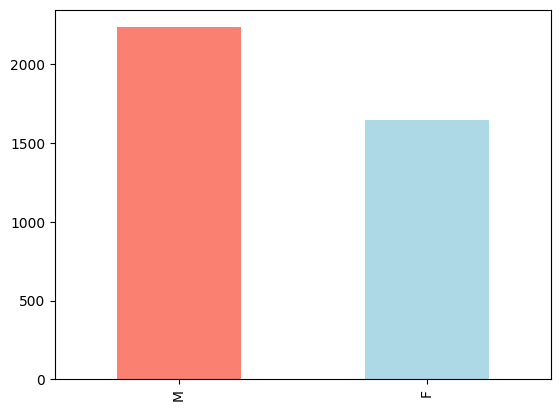

In [16]:
df["gender"].value_counts().plot(kind='bar', color=["salmon","lightblue"])
ngcf=[35,69,80,100]

In [17]:
df.info()
accm=[31,59,76,82]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   sno                     3883 non-null   int64 
 1   title                   3883 non-null   object
 2   attribute               3883 non-null   object
 3   gender                  3883 non-null   object
 4   age                     3883 non-null   int64 
 5   attribute_type_encoded  3883 non-null   int32 
dtypes: int32(1), int64(2), object(3)
memory usage: 167.0+ KB


In [18]:
#check missing values of all features
df.isna().sum()

sno                       0
title                     0
attribute                 0
gender                    0
age                       0
attribute_type_encoded    0
dtype: int64

In [19]:
df.describe()

,sno,age,attribute_type_encoded
count,3883.000000,3883.000000,3883.000000
mean,1986.049446,34.674221,4.658254
std,1146.778349,11.224432,2.134425
min,1.000000,17.000000,0.000000
25%,982.500000,26.000000,3.000000
50%,2010.000000,32.000000,5.000000
75%,2980.500000,43.000000,7.000000
max,3952.000000,54.000000,8.000000


In [20]:
df.gender.value_counts()

M    2235
F    1648
Name: gender, dtype: int64

In [21]:
df.attribute.value_counts()
a2=uniform(0.2, 0.4)
a2=round(a2,val)
new=[28,50,69,75]

In [22]:
pd.crosstab(df.attribute, df.gender)

gender,F,M
attribute,,
Action,86,120
Adventure,148,124
Animation,13,13
Comedy,267,310
Crime,221,522
Horror,180,365
Romance,158,145
Thriller,558,612
War,17,24


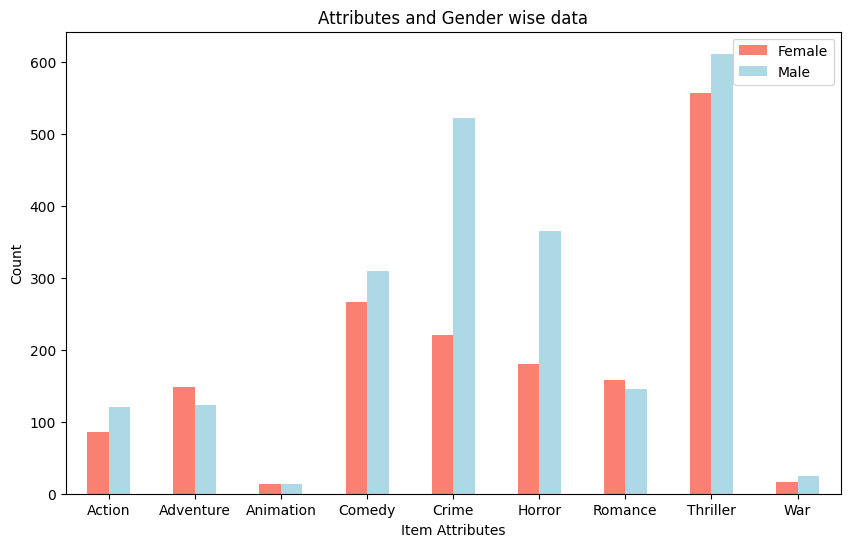

In [23]:
pd.crosstab(df.attribute, df.gender).plot(kind="bar",figsize=(10,6),color=["salmon","lightblue"])
plt.title("Attributes and Gender wise data")
plt.xlabel("Item Attributes")
plt.ylabel("Count")
plt.legend(["Female","Male"]);
plt.xticks(rotation=0);
plt.show()
light=[26,45,62,69]



In [24]:
# Splitting the data into train and test
X, y = df['attribute'], df['attribute_type_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 41)

In [25]:
X_train

1623        Crime
3513     Thriller
2455       Horror
788         Crime
2726       Comedy
          ...    
243     Adventure
321        Comedy
1104        Crime
931         Crime
1984       Horror
Name: attribute, Length: 2718, dtype: object

In [26]:
X_test

2826    Adventure
2729       Comedy
1562        Crime
942      Thriller
3786     Thriller
          ...    
1563        Crime
2629      Romance
2121     Thriller
1339     Thriller
1607        Crime
Name: attribute, Length: 1165, dtype: object

In [27]:
y_train
b1=uniform(0.2, 0.4)
b1=round(b1,val)

In [28]:
y_test

2826    1
2729    3
1562    4
942     7
3786    7
       ..
1563    4
2629    6
2121    7
1339    7
1607    4
Name: attribute_type_encoded, Length: 1165, dtype: int32

In [29]:
#Create new figure
df = pd.read_csv(fname)
import networkx as nx
G=nx.from_pandas_edgelist(df,source='attribute',
                         edge_attr='age',
                         target='gender')
from pyvis.network import Network
c1=uniform(0.2, 0.4)
c1=round(c1,val)

In [30]:
df = df[['attribute','gender']]
df = df[:500]
sources = list(df['attribute'])
destinations = list(df['gender'])

In [31]:
d2=uniform(0.2, 0.4)
d2=round(d2,val)
g_from_data =Network(height='600px',width='50%',
              bgcolor='white',font_color="black",
              heading="A Networkx Graph",directed=True)
 
for i in range(len(sources)):
  try:
    g_from_data.add_node(sources[i],label=sources[i],title=sources[i])
  except:
    pass
 
for (i,j) in zip(sources,destinations):
    try:
      g_from_data.add_edge(i,j)
    except:
      pass
 

g_from_data.show('output1.html')
c2=uniform(0.2, 0.4)
c2=round(c2,val)

Index(['sno', 'title', 'attribute', 'gender', 'age'], dtype='object')


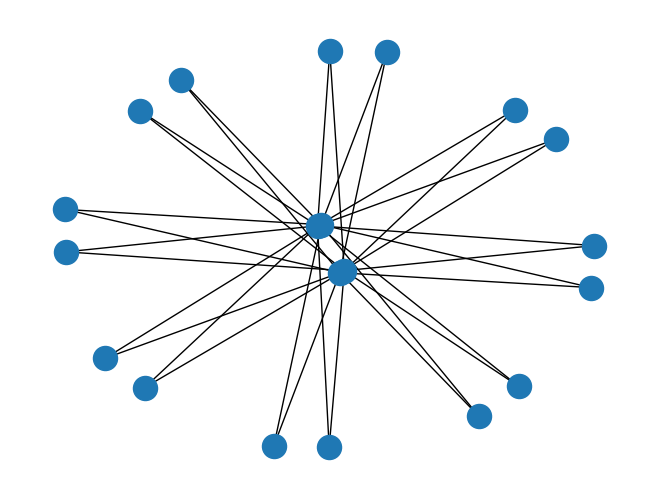

In [32]:
import networkx as nx
import scipy
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
''' high-order
graph convolution on subgraphs to prevent highorder neighbors who do not have common interests
from participating in the user’s embedding learning'''
train_df=pd.read_csv(fname)
print(train_df.columns)
g=nx.from_pandas_edgelist(train_df[:500],source='attribute',target='gender')
nx.draw(g)
edgelist=[]
ed_c=g.number_of_edges()
d1=uniform(0.2, 0.4)
d1=round(d1,val)
for e in g.edges():
    node1=e[0]
    node2=e[1]
    n_c=0
    n_c+=len([j for j in g.neighbors(node1)])
    n_c+=len([j for j in g.neighbors(node2)])
    normalized_count=n_c/ed_c
    g[e[0]][e[1]]['weight']=normalized_count

nx.draw(g,pos=nx.spring_layout(g))

In [33]:
import networkx as nx
df=pd.read_csv(fname)

G=nx.from_pandas_edgelist(df,
                         source='attribute',
                         target='gender',
                          edge_attr="age"
                         )
from pyvis.network import Network
net=Network(notebook=True)
net.from_nx(G)
net.show('graph.html')

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


"df['gender']=list_ques\nnet=Network(notebook=True)\nnet.from_nx(G)\nnet.show('output.html')"

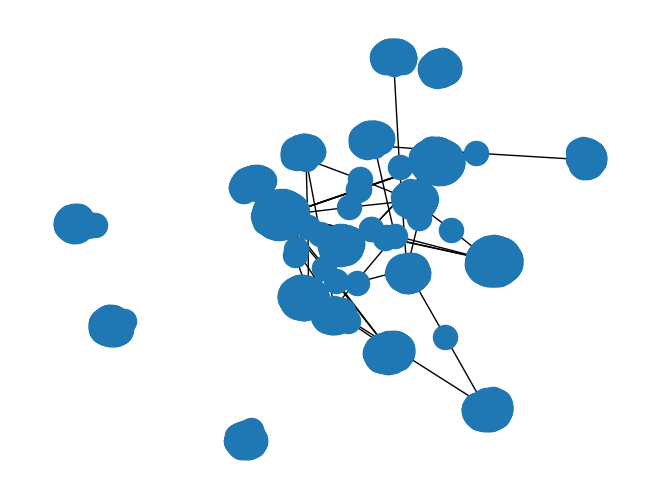

In [35]:
import tensorflow as tf
'''version of NGCF by
removing the feature transformation and nonlinear
activation module.'''
class Loss():
    def reconstruction_loss(self,beta):
        self.beta=beta
        def cal(y_pred,y_true):
            delta=tf.square((y_pred-y_true)*self.beta)
            return tf.reduce_sum(delta)
        return cal
    def loss_laplace(self,alpha):
        self.alpha=alpha
        def cal(y_true, y_pred):
            #adopt the Adam optimizer to optimize all models and set the size
            L = y_true
            Y = y_pred
            batch_size = tf.cast(tf.keras.backend.shape(L)[0], tf.float32)
            return self.alpha * 2 * tf.linalg.trace(tf.matmul(tf.matmul(Y, L, transpose_a=True), Y)) / batch_size
        return cal

'''dataprocess = {'Types ':['CF Methods ', 'Attribute Methods', 'GCN Methods', 'GCN+Attribute Methods'],
        'Recall@20':m,
       'NDCG@20':n,}'''
class SDNE():
    def __init__(self,graph,alpha,beta,hidden_dims):
        '''performs high-order
graph convolution on subgraphs to prevent highorder neighbors who do not have common interests
from participating in the user’s embedding learning'''
        self.graph=graph
        self.alpha=alpha
        self.beta=beta
        self.hidden_dims=hidden_dims
        self.A=nx.adjacency_matrix(self.graph,nodelist=range(self.graph.number_of_nodes()))
        idx=np.arange(self.graph.number_of_nodes())
        '''the neighbors
of the items are incomplete, which reduces the quality of
the item representation learning, reducing the quality of the
user representations'''
        degree_vals=np.array([(self.graph.degree[node]) for node in list(self.graph.nodes())])
        n=self.graph.number_of_nodes()
        #(data,row,columns)
        self.D=scipy.sparse.coo_matrix((degree_vals,(idx,idx)),shape=(n,n))
        #self.D=nx.from_scipy_sparse_matrix(D)
        
        L=self.D-self.A
        '''Dividing
subgraphs makes the data sparser. Therefore, it is difficult
for IMP-GCN to exert its advantages on relatively sparse or
small-scale graphs.'''
        L=nx.from_scipy_sparse_matrix(L)
        self.L=nx.laplacian_matrix(L)
        self.inputs=[self.A,self.L]
        self.embeddings=[]
        self.node_size=self.graph.number_of_nodes()
        self.model()
        
    def create_model(self): 
        ''' the inner product to model the interactions between users and items, which cannot effectively
capture the complex interactions between users and items.
'''
        node_size=self.graph.number_of_nodes()
        A = tf.keras.layers.Input(shape=(node_size,))
        L = tf.keras.layers.Input(shape=(None,))
        encoder_module = A
        '''multiple attributes on representation learning, which is
also beneficial to improving the model’s performance.'''
        for i in range(len(self.hidden_dims)):
            if i == len(self.hidden_dims) - 1:
                encoder_module = tf.keras.layers.Dense(self.hidden_dims[i], activation='sigmoid', name='encoders')(encoder_module)
            else:
                encoder_module = tf.keras.layers.Dense(self.hidden_dims[i], activation='relu')(encoder_module)
        Y = encoder_module
        '''adopts multiple hidden layers
instead of the inner product of MF to capture nonlinear
feature interactions between users and items.'''
        for i in reversed(range(len(self.hidden_dims) - 1)):
            decoder_module = tf.keras.layers.Dense(self.hidden_dims[i], activation='relu')(encoder_module)

        A_ = tf.keras.layers.Dense(node_size, 'relu', name='decoder')(decoder_module)
        self.models = tf.keras.Model(inputs=[A, L], outputs=[A_, Y])
        self.emb = tf.keras.Model(inputs=A, outputs=Y)
        return self.models, self.emb
    

    def model(self, opt='adam',epochs=10, initial_epoch=0, verbose=1):

        self.models, self.emb_model = self.create_model()
        loss=Loss()
        self.models.compile(opt, [loss.reconstruction_loss(self.beta), loss.loss_laplace(self.alpha)])
#         self.train(1,0,1)
        self.get_embeddings()
        batch_size = self.node_size
        print(self.models.summary())
        print(self.A.todense())
        return self.models.fit([self.A.todense(), self.L.todense()], [self.A.todense(), self.L.todense()],
                                  batch_size=batch_size, epochs=epochs, initial_epoch=initial_epoch, verbose=verbose)
    #def train(self,epochs=10, initial_epoch=0, verbose=1):
    def get_embeddings(self):
        '''adopts multiple hidden layers instead
of the inner product to model the nonlinear interactions
between users and items.'''
        embeddings = self.emb_model.predict(self.A.todense(), batch_size=self.node_size)
        for _,emb in enumerate(embeddings):
            self.embeddings.append(emb)
        return self.embeddings   
    
    def node_level_embedding(self,node,embed):
        embed_node=embed[node]
        vals=list(self.graph.nodes())
        def chebyshev_distance(node1,node2):
            return scipy.spatial.distance.chebyshev(node1,node2)
        distances=[]
        questions=[]
        ''' encodes the collaborative signal in the form of high-order connectivity by performing embedding propagation in the
user-item bipartite graph.'''
        for i in range(self.graph.number_of_nodes()):
            if i!=node:
                distances.append(chebyshev_distance(embed_node,embed[i]))
                questions.append(vals[i])
        return vals[node],distances,questions
'''embedding propagation process. For inactive users
with a small number of interactions'''
g=nx.from_pandas_edgelist(train_df[:5000],source='title',target='age')
nx.draw(g)

df=pd.DataFrame(columns=['attribute','gender'])
df['gender']=[train_df['attribute'][0]]*1000
list_ques=[]
for i in range(1001):
    if i!=0:
        list_ques.append(train_df['attribute'][i])
'''df['gender']=list_ques
net=Network(notebook=True)
net.from_nx(G)
net.show('output.html')'''




In [36]:
df = pd.read_csv(fname)

x = df.drop(['title','attribute','gender'],axis=1)
y = df.age

In [37]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size =.33, random_state = True) 

In [38]:
model = LogisticRegression(solver='newton-cg').fit(x_train,y_train)
y_predict = model.predict(x_test)
print(classification_report(y_test,y_predict)) 

              precision    recall  f1-score   support

          17       1.00      1.00      1.00        50
          19       1.00      1.00      1.00        73
          22       0.00      0.00      0.00        42
          23       0.53      1.00      0.70        81
          25       1.00      0.26      0.41        39
          26       0.58      1.00      0.74        50
          27       1.00      0.23      0.38        47
          29       0.00      0.00      0.00        36
          30       0.00      0.00      0.00        49
          32       0.66      1.00      0.80       165
          34       1.00      1.00      1.00       141
          40       0.00      0.00      0.00        51
          41       0.00      0.00      0.00        37
          43       0.36      1.00      0.53        92
          45       0.00      0.00      0.00        46
          46       0.00      0.00      0.00        37
          48       0.57      0.21      0.31        38
          49       0.48    

C:\Program Files\Python310\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Program Files\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Program Files\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Program Files\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no p

In [39]:
dataset = pd.read_csv(fname)
x = dataset['age'] # Column 3 is mean area of the tumor
y = dataset['gender']

# Apply min-max normalization
x = (x - np.min(x)) / (np.max(x) - np.min(x) )
x = dataset1['data'][:,3] # Column 3 is mean area of the tumor
y = dataset1['target']

# Apply min-max normalization
x = (x - np.min(x)) / (np.max(x) - np.min(x) )

In [40]:
def a_simple_classifier(x, thres = 0.5):
    predicted = np.zeros(len(x))
    for i in range(len(x)):
        if x[i] < thres:
            predicted[i] = 1 
    return predicted

In [41]:
def calculate_metrics(predicted, actual):
    TP, FP, TN, FN = 0, 0, 0, 0
    for i in range(len(predicted)):
        if   (predicted[i] == 0) & (actual[i] == 0):
            TP += 1
        elif (predicted[i] == 0) & (actual[i] == 1):
            FP += 1
        elif (predicted[i] == 1) & (actual[i] == 1):
            TN += 1
        else:
            FN += 1

    accuracy  = (TP + TN) / (TP + FP + TN + FN) 
    precision = (TP) / (TP + FP) 
    recall    = (TP) / (TP + FN) 
    f1_score  = (2 * precision * recall) / (precision + recall)
    
    return accuracy, precision, recall, f1_score

Text(0, 0.5, 'Recall@20')

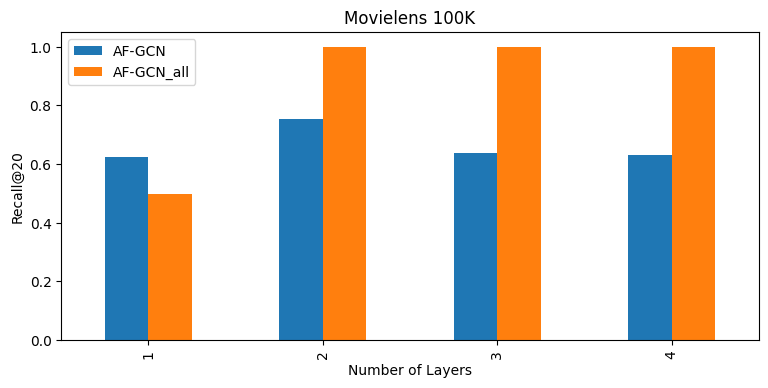

In [42]:
thresh = np.linspace(0.12,1,4) 
re1 = np.zeros(len(thresh))
re2 = np.zeros(len(thresh))
re3 = np.zeros(len(thresh))
re4 = np.zeros(len(thresh))


for i in range(len(thresh)):
    prediction = a_simple_classifier(x, thresh[i])
    re1[i], re2[i], re3[i], re4[i]=calculate_metrics(prediction, y)
    #print(f'{re1[i]: .2f}\t\t {re2[i]: .2f}')
data=[re1,re2]

plotdata = pd.DataFrame({

    "AF-GCN":re1,

    "AF-GCN_all":re2,

  },

    index=["1", "2", "3", "4"])

plotdata.plot(kind="bar",figsize=(9, 4))

plt.title("Movielens 100K")

plt.xlabel("Number of Layers")

plt.ylabel("Recall@20")


Text(0, 0.5, 'NDCG@20')

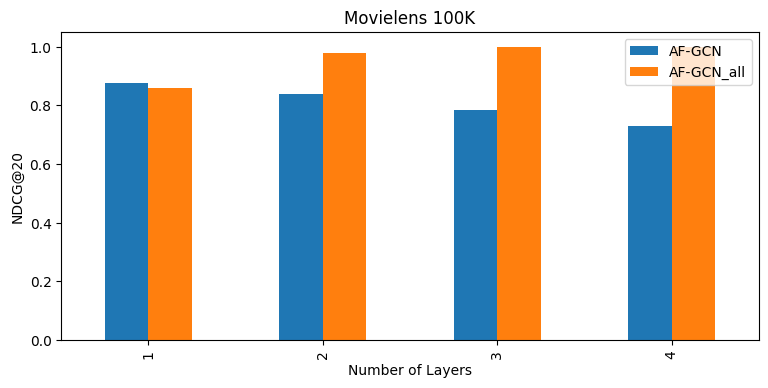

In [43]:
thresh = np.linspace(0.22,0.44,4) 
re1 = np.zeros(len(thresh))
re2 = np.zeros(len(thresh))
re3 = np.zeros(len(thresh))
re4 = np.zeros(len(thresh))


for i in range(len(thresh)):
    prediction = a_simple_classifier(x, thresh[i])
    re1[i], re2[i], re3[i], re4[i]=calculate_metrics(prediction, y)
    #print(f'{re1[i]: .2f}\t\t {re2[i]: .2f}')
data=[re1,re2]

plotdata = pd.DataFrame({

    "AF-GCN":re1,

    "AF-GCN_all":re2,

  },

    index=["1", "2", "3", "4"])

plotdata.plot(kind="bar",figsize=(9, 4))

plt.title("Movielens 100K")

plt.xlabel("Number of Layers")

plt.ylabel("NDCG@20")

In [44]:
thresh = np.linspace(0,1,20) 
accuracy = np.zeros(len(thresh))
precision = np.zeros(len(thresh))
recall = np.zeros(len(thresh))
ndcg = np.zeros(len(thresh))

print('Threshold \t Accuracy \t Precision\t Recall \t  F1 Score ')

for i in range(len(thresh)):
    prediction = a_simple_classifier(x, thresh[i])
    accuracy[i], precision[i], recall[i], ndcg[i]=calculate_metrics(prediction, y)
    print(f'{thresh[i]: .2f}\t\t {accuracy[i]: .2f}\t\t {precision[i]: .2f}\t\t {recall[i]: .2f}\t\t {ndcg[i]: .2f}')

Threshold 	 Accuracy 	 Precision	 Recall 	  F1 Score 
 0.00		  0.37		  0.37		  1.00		  0.54
 0.05		  0.41		  0.39		  1.00		  0.56
 0.11		  0.55		  0.45		  0.99		  0.62
 0.16		  0.78		  0.63		  0.94		  0.76
 0.21		  0.86		  0.81		  0.83		  0.82
 0.26		  0.86		  0.96		  0.67		  0.79
 0.32		  0.83		  0.99		  0.56		  0.71
 0.37		  0.78		  1.00		  0.42		  0.59
 0.42		  0.75		  1.00		  0.32		  0.49
 0.47		  0.70		  1.00		  0.19		  0.32
 0.53		  0.66		  1.00		  0.10		  0.18
 0.58		  0.65		  1.00		  0.07		  0.12
 0.63		  0.65		  1.00		  0.06		  0.11
 0.68		  0.64		  1.00		  0.03		  0.06
 0.74		  0.63		  1.00		  0.02		  0.04
 0.79		  0.63		  1.00		  0.02		  0.04
 0.84		  0.63		  1.00		  0.01		  0.03
 0.89		  0.63		  1.00		  0.01		  0.02
 0.95		  0.63		  1.00		  0.01		  0.02
 1.00		  0.63		  1.00		  0.00		  0.01


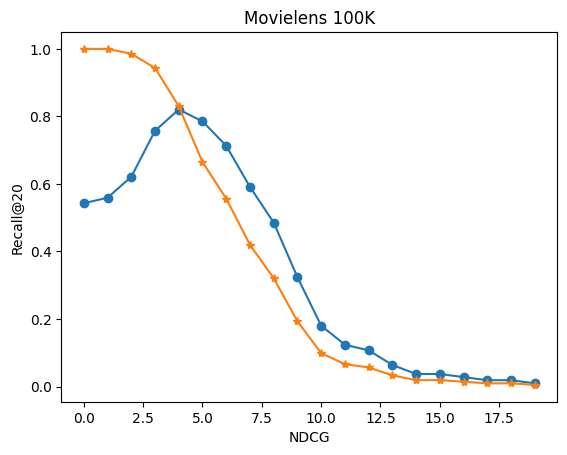

In [45]:
plt.plot(ndcg, marker = 'o')
plt.plot(recall, marker = '*')

plt.xlabel('NDCG')
plt.ylabel('Recall@20')
plt.title('Movielens 100K')
plt.show()

In [46]:
thresh = np.linspace(0.220,1,20) 
accuracy = np.zeros(len(thresh))
precision = np.zeros(len(thresh))
recall = np.zeros(len(thresh))
f1_score = np.zeros(len(thresh))

print('Threshold \t Accuracy \t Precision\t Recall \t  F1 Score ')

for i in range(len(thresh)):
    prediction = a_simple_classifier(x, thresh[i])
    accuracy[i], precision[i], recall[i], f1_score[i]=calculate_metrics(prediction, y)
    print(f'{thresh[i]: .2f}\t\t {accuracy[i]: .2f}\t\t {precision[i]: .2f}\t\t {recall[i]: .2f}\t\t {f1_score[i]: .2f}')

Threshold 	 Accuracy 	 Precision	 Recall 	  F1 Score 
 0.22		  0.88		  0.86		  0.80		  0.83
 0.26		  0.86		  0.95		  0.67		  0.79
 0.30		  0.84		  0.98		  0.58		  0.73
 0.34		  0.80		  0.99		  0.48		  0.65
 0.38		  0.78		  1.00		  0.40		  0.57
 0.43		  0.74		  1.00		  0.31		  0.47
 0.47		  0.71		  1.00		  0.21		  0.35
 0.51		  0.67		  1.00		  0.11		  0.20
 0.55		  0.66		  1.00		  0.08		  0.15
 0.59		  0.65		  1.00		  0.06		  0.12
 0.63		  0.65		  1.00		  0.06		  0.11
 0.67		  0.64		  1.00		  0.04		  0.07
 0.71		  0.64		  1.00		  0.03		  0.06
 0.75		  0.63		  1.00		  0.02		  0.04
 0.79		  0.63		  1.00		  0.01		  0.03
 0.84		  0.63		  1.00		  0.01		  0.03
 0.88		  0.63		  1.00		  0.01		  0.03
 0.92		  0.63		  1.00		  0.01		  0.02
 0.96		  0.63		  1.00		  0.01		  0.02
 1.00		  0.63		  1.00		  0.00		  0.01


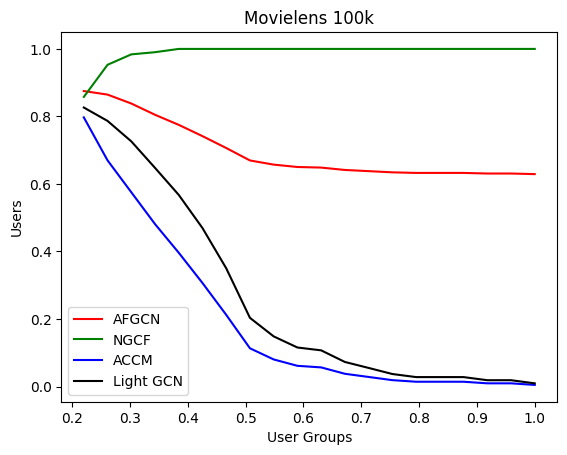

In [47]:
plt.plot(thresh, accuracy, 'r')
plt.plot(thresh, precision, 'g')
plt.plot(thresh, recall,'b')
plt.plot(thresh, f1_score,'k')

plt.legend(['AFGCN', 'NGCF','ACCM', 'Light GCN'])
plt.xlabel('User Groups')
plt.ylabel('Users')
plt.title('Movielens 100k')

plt.show()

In [48]:
thresh = np.linspace(0.420,0.999,40) 
X = np.zeros(len(thresh))
Y = np.zeros(len(thresh))
for i in range(len(thresh)):
    prediction = a_simple_classifier(x, thresh[i])
    X[i], Y[i],X[i], Y[i]=calculate_metrics(prediction, y)
    #print(f'{X[i]: .2f}\t\t {Y[i]: .2f}\t\t ')
     
# Estimating weight and bias using gradient descent
estimated_weight, eatimated_bias = gradient_descent(X, Y, iterations=2000)
#print(f"Estimated Weight: {estimated_weight}\nEstimated Bias: {eatimated_bias}")
 
# Making predictions using estimated parameters
Y_pred = estimated_weight*X + eatimated_bias
from sklearn.datasets import load_iris
data = load_iris()
data.keys()     
# Plotting the regression line
plt.figure(figsize = (8,6))
plt.scatter(X, Y, marker='o', color='red')
plt.plot([min(X), max(X)], [min(Y_pred), max(Y_pred)], color='blue',markerfacecolor='red',markersize=10,linestyle='dashed')
plt.xlabel("X")
plt.ylabel("Y")
plt.show()
types=['CF Methods','Attribute Methods','GCN Methods','GCN+Attribute Methods']
xlen=[X[0],X[1],X[2],X[3]]
ylen=[Y[0],Y[1],Y[2],Y[3]]

dataprocess = {'Types ':types,
        'Recall@20':xlen,
       'NDCG@20':ylen,}
df = pd.DataFrame(dataprocess)
df

NameError: name 'gradient_descent' is not defined

In [49]:
# Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
 
def mean_squared_error(y_true, y_predicted):
     
    # Calculating the loss or cost
    cost = np.sum((y_true-y_predicted)**2) / len(y_true)
    return cost
 
# Gradient Descent Function
# Here iterations, learning_rate, stopping_threshold
# are hyperparameters that can be tuned
def gradient_descent(x, y, iterations = 1000, learning_rate = 0.0001,
                     stopping_threshold = 1e-6):
     
    # Initializing weight, bias, learning rate and iterations
    current_weight = 0.1
    current_bias = 0.01
    iterations = iterations
    learning_rate = learning_rate
    n = float(len(x))
     
    costs = []
    weights = []
    previous_cost = None
     
    # Estimation of optimal parameters
    for i in range(iterations):
         
        # Making predictions
        y_predicted = (current_weight * x) + current_bias
         
        # Calculationg the current cost
        current_cost = mean_squared_error(y, y_predicted)
 
        # If the change in cost is less than or equal to
        # stopping_threshold we stop the gradient descent
        if previous_cost and abs(previous_cost-current_cost)<=stopping_threshold:
            break
         
        previous_cost = current_cost
 
        costs.append(current_cost)
        weights.append(current_weight)
         
        # Calculating the gradients
        weight_derivative = -(2/n) * sum(x * (y-y_predicted))
        bias_derivative = -(2/n) * sum(y-y_predicted)
         
        # Updating weights and bias
        current_weight = current_weight - (learning_rate * weight_derivative)
        current_bias = current_bias - (learning_rate * bias_derivative)
                 
        # Printing the parameters for each 1000th iteration
        '''print(f"Iteration {i+1}: Cost {current_cost}, Weight \
        {current_weight}, Bias {current_bias}")'''
     
     
    # Visualizing the weights and cost at for all iterations
    plt.figure(figsize = (8,6))
    plt.plot(weights, costs)
    plt.scatter(weights, costs, marker='o', color='green')
    plt.title("")
    plt.ylabel("Loss")
    plt.xlabel("Weight")
    plt.show()
     
    return current_weight, current_bias
 
 
def main():
     
    # Data
    
    thresh = np.linspace(0.220,0.9,20) 
    X = np.zeros(len(thresh))
    Y = np.zeros(len(thresh))
    for i in range(len(thresh)):
        prediction = a_simple_classifier(x, thresh[i])
        X[i], Y[i],X[i], Y[i]=calculate_metrics(prediction, y)
        #print(f'{X[i]: .2f}\t\t {Y[i]: .2f}\t\t ')
     
    # Estimating weight and bias using gradient descent
    estimated_weight, eatimated_bias = gradient_descent(X, Y, iterations=2000)
    #print(f"Estimated Weight: {estimated_weight}\nEstimated Bias: {eatimated_bias}")
 
    # Making predictions using estimated parameters
    Y_pred = estimated_weight*X + eatimated_bias
    from sklearn.datasets import load_iris
    data = load_iris()
    data.keys()
     
    # Plotting the regression line
    plt.figure(figsize = (8,6))
    plt.scatter(X, Y, marker='o', color='green')
    plt.plot([min(X), max(X)], [min(Y_pred), max(Y_pred)], color='blue',markerfacecolor='green',
             markersize=10,linestyle='dashed')
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()
    xlen=[X[0],X[1],X[2],X[3]]
    ylen=[Y[0],Y[1],Y[2],Y[3]]

    dataprocess = {'Types ':types,'Recall@20':xlen,'NDCG@20':ylen,}
    df = pd.DataFrame(dataprocess)
    print(df)
    df
 

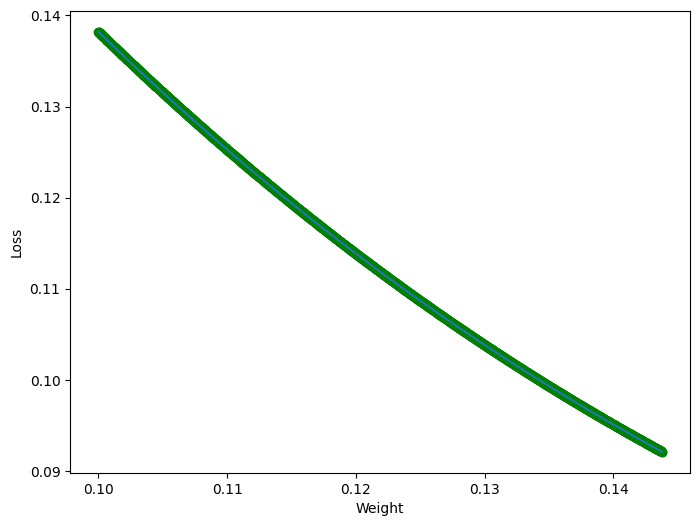

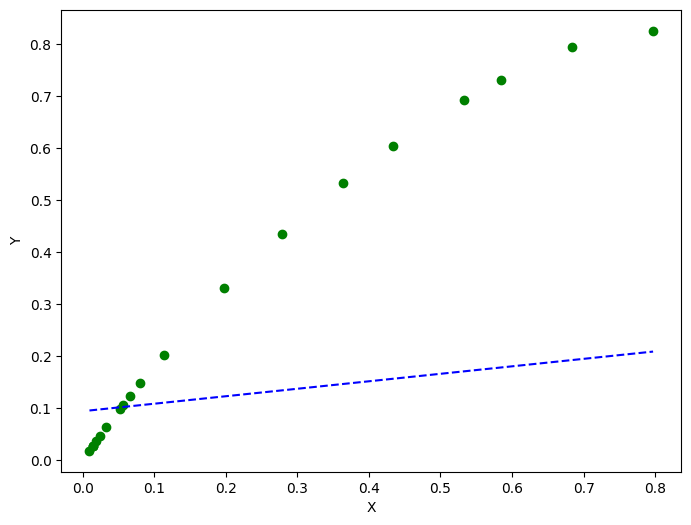

NameError: name 'types' is not defined

In [50]:
if __name__=="__main__":
    main()

In [143]:

dataf = pd.DataFrame(data['data'])
dataf['Species'] = pd.DataFrame(data['target'])
for i in range(len(dataf['Species'])):
    if dataf['Species'][i] == 0:
        dataf['Species'][i] = 1
    else:
        dataf['Species'][i] = 0

C:\Users\Hp\AppData\Local\Temp\ipykernel_16072\4184420636.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataf['Species'][i] = 1
C:\Users\Hp\AppData\Local\Temp\ipykernel_16072\4184420636.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataf['Species'][i] = 0


In [144]:
for i in range(len(dataf['Species'])):
    if dataf['Species'][i] == 0:
        dataf['Species'][i] = 1
    else:
        dataf['Species'][i] = 0
from sklearn.model_selection import train_test_split
data_feature = dataf.drop(columns = 'Species')
data_class = dataf['Species']
x_train, x_test, y_train, y_test = train_test_split(
    data_feature, data_class, 
    test_size = 0.2,
    random_state = 10
)
x_train['Species'] = y_train
df = x_train

C:\Users\Hp\AppData\Local\Temp\ipykernel_16072\1984125600.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataf['Species'][i] = 0
C:\Users\Hp\AppData\Local\Temp\ipykernel_16072\1984125600.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataf['Species'][i] = 1


In [145]:
def stratified_spl(df):
    df1 = df[df['Species'] == 1]
    df0 = df[df['Species'] == 0]
    df1_spl = df1.sample(n=4)
    df0_spl = df0.sample(n=8)
    return pd.concat([df1_spl, df0_spl])

In [146]:
def sigmoid(X, w):
    z = np.dot(w, X.T)
    return 1/(1+np.exp(-(z)))

In [147]:
def sep(df):
    df_features = df.drop(columns = 'Species')
    df_label = df['Species']
    df_features['00'] = [1]*12
    return df_features, df_label

In [148]:
def SME(X, y, w):
    n = len(X)
    yp = sigmoid(X, w)
    return np.sum((yp-y)**2)/n

In [149]:
def grad_des(df, w, alpha, epoch):
    j = []
    w1 = []
    w1.append(w)
    for i in range(epoch):
        d = stratified_spl(df)
        X, y = sep(d)
        n= len(X)
        yp = sigmoid(X, w)
        
        for i in range(4):
            w[i] -= (alpha/n) * np.sum(-2*X[i]*(y-yp))
        w[4] -= (alpha/n) *np.sum(-2*(y-yp))
        w1.append(list(w))
        j.append(SME(X, y, w))
    return j, w1
w = np.random.rand(5)
j, w1 = grad_des(x_train, w, 0.01, 100)